# Определение возраста покупателей

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

Сетевой супермаркет хочет внедрить систему компьютерного зрения для фотофиксация в прикассовой зоне для определения возраста клиентов, чтобы:
    - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    - контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

In [9]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,AvgPool2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

## Исследовательский анализ данных

In [11]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [12]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


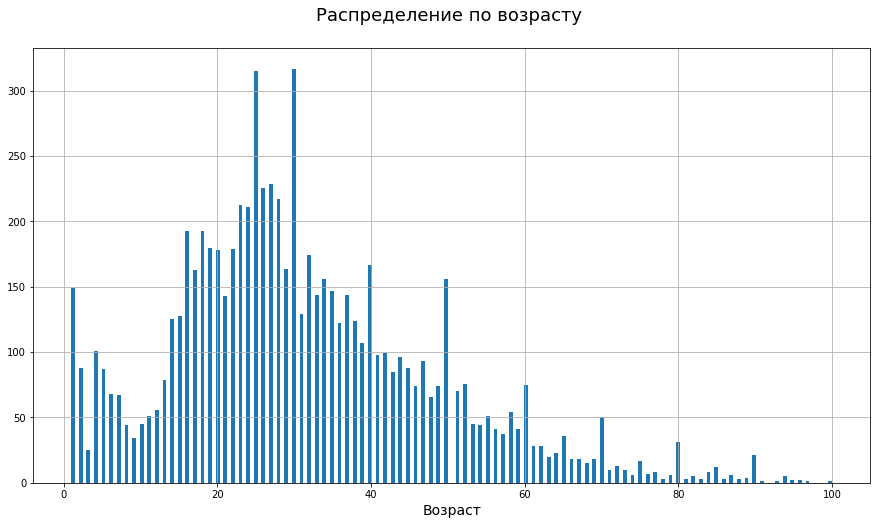

In [19]:
plt.figure(figsize=(15,8))
labels['real_age'].hist(bins=200)#,range=(30,100))
plt.xlabel('Возраст', fontsize=14)
plt.title('Распределение по возрасту \n', fontsize=18);

Распределение по возрастам близко к нормальному. Есть два пика: до 10 лет и от 20 до 30 лет. Распределение скошено влево. Больше всего представлено фотографий людей в возрасте от 20 до 30 лет.

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [23]:
features,target=next(datagen_flow)

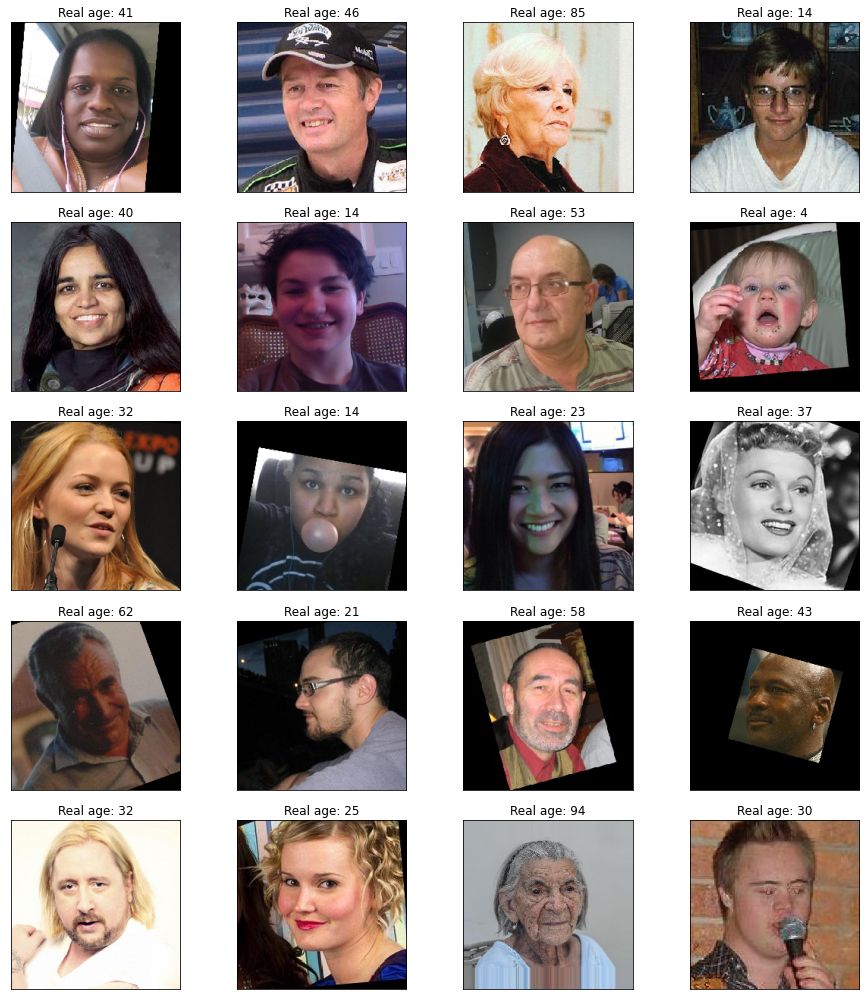

In [24]:
fig = plt.figure(figsize=(14,14))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.title('Real age: ' + str(target[i+1]))
    plt.imshow(features[i+1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В датасете всего 7 591 объектов. Минимальный возраст людей на фото - 1 год, максимальный - 100 лет. Большая часть фото людей в возрасте от 20 до 40 лет. Можно предположить, что модель хорошо обучится на распознование именно этого возраста. Так средний возраст людей на фото составляет 31 год, Медианный возраст - 29 лет. Что объясняется длинным хвостом высоких значений справа. Также обратим внимание на всплески значений для возрастов 25, 30, 40, 50, 60, 70, 80, 90 лет. Возможно это связано с тем, что для многих фото возраст указан не точно, а примерно.

Объём датасета недостаточен для полноценного обучения модели, именно поэтому мы воспоьзуемся весами уже обученной на большом наборе данных ImageNet модели. Это позволит ускорить процесс обучения и улучшить результаты. "Замораживать" слои не будем.

По выведеным фото можно увидеть, что в датасете представленны как цветные фото, так и черно-белые. Некоторые фото уже повернуты. Поскольку данных достаточно мало, в качестве метода аугментации можно попробовать зеркальное отражение по горизонтали и смещение. Поворот уже есть в датасете, его использовать не будем, а отражение по вертикали в данном случае не имеет смысла - скорее всего в объектив камеры магазина не попадёт перевернутое лицо.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    steps_per_epoch = len(train_data)
    validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Train for 356 steps, validate for 119 steps
Epoch 1/20
2024-02-24 11:01:22.217881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-24 11:01:22.591049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 80s - loss: 208.0462 - mae: 11.0001 - val_loss: 293.8908 - val_mae: 12.8244
Epoch 2/20
356/356 - 43s - loss: 137.6033 - mae: 8.9803 - val_loss: 616.4085 - val_mae: 20.2163
Epoch 3/20
356/356 - 43s - loss: 110.0595 - mae: 7.9708 - val_loss: 144.3824 - val_mae: 8.8859
Epoch 4/20
356/356 - 44s - loss: 91.7677 - mae: 7.2720 - val_loss: 116.4068 - val_mae: 8.3357
Epoch 5/20
356/356 - 43s - loss: 88.7763 - mae: 7.1425 - val_loss: 244.0825 - val_mae: 12.1858
Epoch 6/20
356/356 - 42s - loss: 73.0343 - mae: 6.5316 - val_loss: 108.2336 - val_mae: 7.8148
Epoch 7/20
356/356 - 41s - loss: 57.7582 - mae: 5.7943 - val_loss: 121.8947 - val_mae: 8.5796
Epoch 8/20
356/356 - 41s - loss: 49.8725 - mae: 5.4112 - val_loss: 114.3230 - val_mae: 8.0290
Epoch 9/20
356/356 - 41s - loss: 42.8088 - mae: 5.0080 - val_loss: 144.5517 - val_mae: 9.0784
Epoch 10/20
356/356 - 41s - loss: 33.9582 - mae: 4.4843 - val_loss: 112.0885 - val_mae: 8.1339
Epoch 11/20
356/356 - 43s - loss: 27.8032 - mae: 4.0724 - val_loss: 79.3207 - val_mae: 6.7026
Epoch 12/20
356/356 - 43s - loss: 26.4274 - mae: 3.9508 - val_loss: 124.3537 - val_mae: 8.8446
Epoch 13/20
356/356 - 41s - loss: 26.4776 - mae: 3.9456 - val_loss: 113.0094 - val_mae: 8.2556
Epoch 14/20
356/356 - 41s - loss: 24.6374 - mae: 3.8164 - val_loss: 93.3378 - val_mae: 7.1982
Epoch 15/20
356/356 - 41s - loss: 22.4787 - mae: 3.6310 - val_loss: 110.2883 - val_mae: 8.2489
Epoch 16/20
356/356 - 41s - loss: 20.1527 - mae: 3.4603 - val_loss: 84.5216 - val_mae: 6.7538
Epoch 17/20
356/356 - 41s - loss: 18.3974 - mae: 3.3299 - val_loss: 96.4885 - val_mae: 7.4294
Epoch 18/20
356/356 - 42s - loss: 18.8045 - mae: 3.3447 - val_loss: 84.0441 - val_mae: 6.8996
Epoch 19/20
356/356 - 43s - loss: 19.6194 - mae: 3.3897 - val_loss: 98.6391 - val_mae: 7.5400
Epoch 20/20
356/356 - 43s - loss: 17.8027 - mae: 3.2413 - val_loss: 81.3341 - val_mae: 6.7958
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 81.3341 - mae: 6.7958
Test MAE: 6.7958

```

## Анализ обученной модели

В данном проекте была поставлена задача разработать нейросеть для супермаркета «Хлеб-Соль». Сеть должна была определить возраст покупателя, чтобы анализировать покупки и предлагать ему товары.

В вашем распоряжении набор фотографий людей с указанием возраста. В датасете всего 7 591 объектов. Минимальный возраст людей на фото - 1 год, максимальный - 100 лет. Большая часть фото людей в возрасте от 20 до 40 лет. Так средний возраст людей на фото составляет 31 год, Медианный возраст - 29 лет. Что объясняется длинным хвостом высоких значений справа. Также обратим внимание на всплески значений для возрастов 25, 30, 40, 50, 60, 70, 80, 90 лет. Возможно это связано с тем, что для многих фото возраст указан не точно, а примерно.

Объём датасета недостаточен для полноценного обучения модели, именно поэтому мы использовали веса уже обученной на большом наборе данных ImageNet модели.

В датасете представленны как цветные фото, так и черно-белые. Некоторые фото уже повернуты. Поскольку данных достаточно мало, в качестве метода аугментации мы использовали зеркальное отражение по горизонтали.

Мы использовали предобученную сеть ResNet50. Модель обучалась 20 эпох. Была выбрана функция оптимизации Adam с шагом lr=0.0005.
На тестовой выборке значение MAE составила 6.7958.